In [19]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

In [20]:
# Load Data for all Folds
folds_data = {}
all_images_types = []
all_masks = []

In [21]:
for fold_num in range(1, 4):
    print(f"\nLoading data for Fold {fold_num} ...")
    images_path = f'../../PanNuke_Dataset/fold_{fold_num}/Fold {fold_num}/images/fold{fold_num}/images.npy'
    masks_path = f'../../PanNuke_Dataset/fold_{fold_num}/Fold {fold_num}/masks/fold{fold_num}/masks.npy'
    types_path = f'../../PanNuke_Dataset/fold_{fold_num}/Fold {fold_num}/images/fold{fold_num}/types.npy'
    images = np.load(images_path)
    masks = np.load(masks_path)
    types = np.load(types_path)

    folds_data[f'fold_{fold_num}'] = {
        'images': images,
        'masks': masks,
        'types': types
    }

    all_images_types.extend(types)
    all_masks.append(masks)
    print(f"Fold {fold_num} data loading completed.")


Loading data for Fold 1 ...
Fold 1 data loading completed.

Loading data for Fold 2 ...
Fold 2 data loading completed.

Loading data for Fold 3 ...
Fold 3 data loading completed.


In [22]:
nuclei_classes = [0, 1, 2, 3, 4]

In [23]:
def contains_all_nuclei(mask):
    for channel in nuclei_classes:
        if np.max(mask[:, :, channel]) == 0:
            return False
    return True

##### Matrix 

In [24]:
combined_masks = np.concatenate(all_masks, axis=0)
print(f"\nTotal number of images across all folds: {combined_masks.shape[0]}")


Total number of images across all folds: 7901


In [25]:
num_nuclei_classes = 5 
nuclei_presence_matrix = np.zeros((combined_masks.shape[0], num_nuclei_classes), dtype=int)

In [26]:
print("Populating nuclei presence matrix...")
for i in range(combined_masks.shape[0]):
    current_mask = combined_masks[i]
    for j in range(num_nuclei_classes): #channels 0 to 4
        if np.any(current_mask[:, :, j] > 0):
            nuclei_presence_matrix[i, j] = 1


Populating nuclei presence matrix...


In [27]:
print(f"Shape of the nuclei presence matrix: {nuclei_presence_matrix.shape}")

Shape of the nuclei presence matrix: (7901, 5)


In [28]:
print("\nFirst 5 rows of the nuclei presence matrix:")
print(nuclei_presence_matrix[:5])



First 5 rows of the nuclei presence matrix:
[[1 1 1 0 0]
 [1 1 1 0 0]
 [1 0 1 0 0]
 [1 0 0 0 0]
 [1 1 1 0 0]]


In [29]:
all_five_types_present_indices = np.where(np.all(nuclei_presence_matrix == 1, axis=1))[0]
print(f"\nNumber of images containing all 5 nuclei types: {len(all_five_types_present_indices)}")


Number of images containing all 5 nuclei types: 1


##### Find the file with all five classes from a same tissue type 

In [30]:
class_names = [
        "Neoplastic",       # Channel 0
        "Inflammatory",     # Channel 1
        "Connective",       # Channel 2
        "Dead Cells",       # Channel 3
        "Epithelial",       # Channel 4
        "Background"        # Channel 5
]

type_colors = [
    [255, 0, 0],    # Red for Neoplastic
    [0, 255, 0],    # Green for Inflammatory
    [0, 0, 255],    # Blue for Connective
    [255, 255, 0],  # Yellow for Dead Cells
    [255, 165, 0]   # Orange for Epithelial
]

In [31]:
nuclei_classes_to_check = [0, 1, 2, 3, 4] # The 5 nuclei channels

In [32]:
selected_image_data = None
original_idx_in_combined_masks = -1
current_idx_in_combined = 0 

In [33]:
for fold_name, data in folds_data.items():
        images = data['images']
        masks = data['masks']
        types = data['types']

        for i in range(images.shape[0]):
            if contains_all_nuclei(masks[i]):
                selected_image_data = (images[i], masks[i], types[i])
                print(f"Found 1 image of tissue type '{types[i]}' in {fold_name} at its internal index {i} that contains all nuclei classes.")
                original_idx_in_combined_masks = current_idx_in_combined + i
                break # Found the image
            current_idx_in_combined += 1
        if selected_image_data:
            break

Found 1 image of tissue type 'Colon' in fold_3 at its internal index 1730 that contains all nuclei classes.


In [34]:
img_to_plot, mask_to_plot, type_to_plot = selected_image_data

org_image_uint8 = img_to_plot.astype(np.uint8)
composite_instance_mask_rgb = np.zeros_like(org_image_uint8, dtype=np.uint8)

for i in range(len(nuclei_classes_to_check)): 
    instance_channel = mask_to_plot[:, :, nuclei_classes_to_check[i]]
    composite_instance_mask_rgb[instance_channel > 0] = type_colors[i]

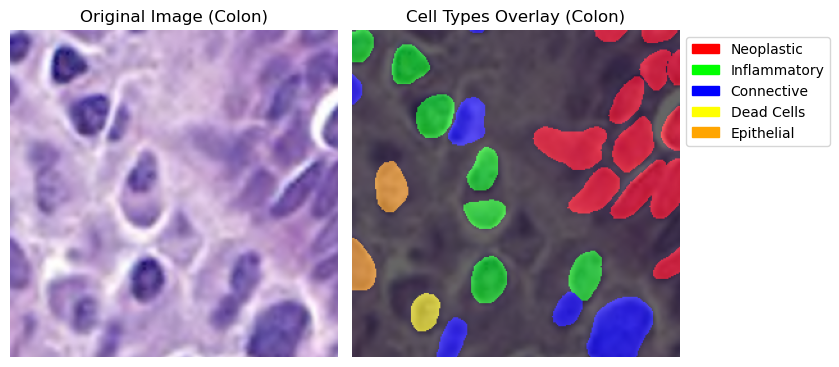

In [35]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(org_image_uint8)
plt.title(f"Original Image ({type_to_plot})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(org_image_uint8)
plt.imshow(composite_instance_mask_rgb, alpha=0.6)
plt.title(f"Cell Types Overlay ({type_to_plot})")
plt.axis('off')

patches = [plt.Rectangle((0,0),1,1, color=np.array(c)/255.) for c in type_colors]
plt.legend(patches, [class_names[i] for i in nuclei_classes_to_check], loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 10})
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

##### Select 10 images from diverse tissue types with good nuclei coverage

In [36]:
print("\n--- Strategy for Selecting 10 Diverse Images for Prediction ---")


--- Strategy for Selecting 10 Diverse Images for Prediction ---


In [37]:
selected_images_for_prediction_indices = []
target_tissue_types = ['Breast']
min_nuclei_types_for_diversity = 4

In [38]:
# Find all global indices that match the target tissue types AND the nuclei diversity criteria
candidate_indices = []
for i in range(combined_masks.shape[0]):
    tissue_type = all_images_types[i]
    if tissue_type in target_tissue_types:
        present_nuclei_count = np.sum(nuclei_presence_matrix[i])
        if present_nuclei_count >= min_nuclei_types_for_diversity:
            candidate_indices.append(i)

In [39]:
print(f"Found {len(candidate_indices)} images from {target_tissue_types} with at least {min_nuclei_types_for_diversity} nuclei types.")

Found 15 images from ['Breast'] with at least 4 nuclei types.


In [40]:
if len(candidate_indices) >= 10:
    selected_images_for_prediction_indices = random.sample(candidate_indices, 10)
    print("Total 10 images selected")
else:
    selected_images_for_prediction_indices = candidate_indices
    print(f"Warning: Only {len(selected_images_for_prediction_indices)} images found matching criteria. Selected all available.")


Total 10 images selected


In [41]:
print(f"\nSelected {len(selected_images_for_prediction_indices)} images for prediction:")
for i, global_idx in enumerate(selected_images_for_prediction_indices):
    tissue_type = all_images_types[global_idx]
    present_nuclei_types = [
        class_names[j] for j in range(num_nuclei_classes)
        if nuclei_presence_matrix[global_idx, j] == 1
    ]
    print(f"Image {i+1} (Global Index: {global_idx}): Tissue Type - {tissue_type}, Nuclei Types Present: {', '.join(present_nuclei_types)}")


Selected 10 images for prediction:
Image 1 (Global Index: 930): Tissue Type - Breast, Nuclei Types Present: Neoplastic, Inflammatory, Connective, Epithelial
Image 2 (Global Index: 178): Tissue Type - Breast, Nuclei Types Present: Inflammatory, Connective, Dead Cells, Epithelial
Image 3 (Global Index: 5761): Tissue Type - Breast, Nuclei Types Present: Inflammatory, Connective, Dead Cells, Epithelial
Image 4 (Global Index: 3443): Tissue Type - Breast, Nuclei Types Present: Neoplastic, Inflammatory, Connective, Epithelial
Image 5 (Global Index: 198): Tissue Type - Breast, Nuclei Types Present: Neoplastic, Inflammatory, Connective, Epithelial
Image 6 (Global Index: 419): Tissue Type - Breast, Nuclei Types Present: Neoplastic, Inflammatory, Connective, Epithelial
Image 7 (Global Index: 2728): Tissue Type - Breast, Nuclei Types Present: Neoplastic, Inflammatory, Connective, Epithelial
Image 8 (Global Index: 2954): Tissue Type - Breast, Nuclei Types Present: Neoplastic, Inflammatory, Connect

In [42]:
def get_image_data_from_global_idx(global_idx_to_find, folds_data):
    current_offset = 0
    for fold_name, data in folds_data.items():
        num_images_in_fold = data['images'].shape[0]
        if global_idx_to_find < current_offset + num_images_in_fold:
            local_idx = global_idx_to_find - current_offset
            # Return image, mask, type, fold_name, local_idx within fold
            return data['images'][local_idx], data['masks'][local_idx], data['types'][local_idx], fold_name, local_idx
        current_offset += num_images_in_fold
    return None, None, None, None, None 

In [43]:
# Example to get the actual image and mask data 
if selected_images_for_prediction_indices:
    first_selected_global_idx = selected_images_for_prediction_indices[0]
    img, mask, img_type, fold, local_idx = get_image_data_from_global_idx(first_selected_global_idx, folds_data)

    if img is not None:
        print(f"\nExample retrieval of first selected image:")
        print(f"  Global Index: {first_selected_global_idx}")
        print(f"  Origin: Fold {fold}, Local Index: {local_idx}")
        print(f"  Tissue Type: {img_type}")
        print(f"  Image Shape: {img.shape}")
        print(f"  Mask Shape: {mask.shape}")
    else:
        print("\nCould not retrieve data for the first selected image (something went wrong with indexing).")
else:
    print("\nNo images were selected based on the criteria.")


Example retrieval of first selected image:
  Global Index: 930
  Origin: Fold fold_1, Local Index: 930
  Tissue Type: Breast
  Image Shape: (256, 256, 3)
  Mask Shape: (256, 256, 6)


In [44]:
# Load all the selected images and their masks
selected_images = []
selected_masks = []
for global_idx in selected_images_for_prediction_indices:
    img, mask, img_type, fold, local_idx = get_image_data_from_global_idx(global_idx, folds_data)
    if img is not None:
        selected_images.append(img)
        selected_masks.append(mask)
    else:
        print(f"Warning: Could not retrieve data for global index {global_idx}. Skipping this index.")
print(f"\nTotal selected images for prediction: {len(selected_images)}")



Total selected images for prediction: 10


In [45]:
selected_images = np.array(selected_images, dtype=object)
selected_masks = np.array(selected_masks, dtype=object)
print(f"Selected images shape: {selected_images.shape}")
print(f"Selected masks shape: {selected_masks.shape}")

Selected images shape: (10, 256, 256, 3)
Selected masks shape: (10, 256, 256, 6)


In [46]:
# Save the selected images and masks for further processing
np.save('raw_files4inference/breast/raw_images/images.npy', selected_images)
np.save('raw_files4inference/breast/masks/masks.npy', selected_masks)
print("\nSelected images and masks saved successfully.")


Selected images and masks saved successfully.


##### Extract and upscale the images for CellViT inference Input


In [47]:
import os
from PIL import Image

In [61]:
output_base_dir = '/media/network/hdd/public_datasets_archive/01_notebooks/pannuke/input-dir/breast'
if not os.path.exists(output_base_dir):
    os.makedirs(output_base_dir)

patches_dir = os.path.join(output_base_dir, 'patches')
metadata_dir = os.path.join(output_base_dir, 'metadata')

In [62]:
os.makedirs(patches_dir, exist_ok=True)
os.makedirs(metadata_dir, exist_ok=True)

In [63]:
print(f"\nPreparing to save {len(selected_images_for_prediction_indices)} images to: {patches_dir}")


Preparing to save 10 images to: /media/network/hdd/public_datasets_archive/01_notebooks/pannuke/input-dir/breast/patches


In [64]:
target_patch_size = (1024, 1024) 

In [65]:
saved_image_paths = []

for i, global_idx in enumerate(selected_images_for_prediction_indices):
    img_np, mask_np, tissue_type, fold_name, local_idx = get_image_data_from_global_idx(global_idx, folds_data)

    if img_np is None:
        print(f"Skipping global index {global_idx}: Data retrieval failed.")
        continue
    
    # Convert image to PIL format and upscale
    img_pil = Image.fromarray(img_np.astype(np.uint8))
    upscaled_img_pil = img_pil.resize(target_patch_size, Image.BICUBIC)
    # save the upscaled image as image_01, image_02, etc.
    image_filename = f'image_{i+1:02d}.png'
    image_path = os.path.join(patches_dir, image_filename)
    upscaled_img_pil.save(image_path)
    saved_image_paths.append(image_path)
    print(f"Saved image {i+1} to {image_path}")

print(f"\nAll {len(saved_image_paths)} images saved to: {patches_dir}")


Saved image 1 to /media/network/hdd/public_datasets_archive/01_notebooks/pannuke/input-dir/breast/patches/image_01.png
Saved image 2 to /media/network/hdd/public_datasets_archive/01_notebooks/pannuke/input-dir/breast/patches/image_02.png
Saved image 3 to /media/network/hdd/public_datasets_archive/01_notebooks/pannuke/input-dir/breast/patches/image_03.png
Saved image 4 to /media/network/hdd/public_datasets_archive/01_notebooks/pannuke/input-dir/breast/patches/image_04.png
Saved image 5 to /media/network/hdd/public_datasets_archive/01_notebooks/pannuke/input-dir/breast/patches/image_05.png
Saved image 6 to /media/network/hdd/public_datasets_archive/01_notebooks/pannuke/input-dir/breast/patches/image_06.png
Saved image 7 to /media/network/hdd/public_datasets_archive/01_notebooks/pannuke/input-dir/breast/patches/image_07.png
Saved image 8 to /media/network/hdd/public_datasets_archive/01_notebooks/pannuke/input-dir/breast/patches/image_08.png
Saved image 9 to /media/network/hdd/public_datas